   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Nu

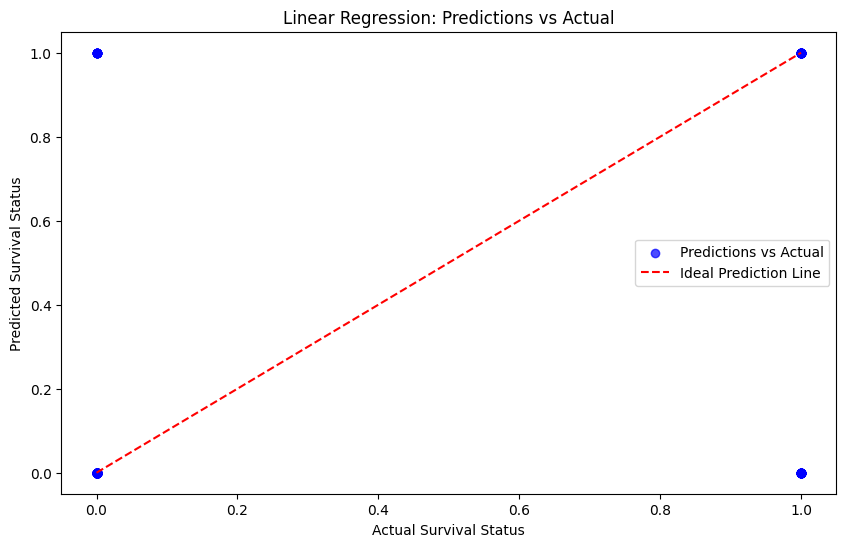


    Predicted Survival Status: Did Not Survive


In [64]:
# Import dependencies
import pandas as pd  # For data processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Train split data
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression # Import the model used
from sklearn.metrics import ( # For model metrics
  accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.impute import SimpleImputer # Make predictions
import matplotlib.pyplot as plt  # For plotting


def load_data_set(path: str) -> pd.DataFrame:
    """Load the dataset from the given path."""
    # Load CSV file into DataFrame
    data_frame: pd.DataFrame = pd.read_csv(path, delimiter=",")
    print(data_frame.head())

    # Identify numerical and categorical columns
    num_cols = data_frame.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = data_frame.select_dtypes(include=["object"]).columns

    # Output column types
    print(f"Numerical columns: {num_cols}")
    print(f"Categorical columns: {cat_cols}")

    # Return processed information
    return num_cols, cat_cols, data_frame


def train_model(input: tuple) -> tuple:
    """Train a Linear Regression model and evaluate performance."""
    # Unpack inputs
    num_cols, cat_cols, data_frame = input

    # Handle missing values
    imputer_num = SimpleImputer(strategy="mean")
    imputer_cat = SimpleImputer(strategy="most_frequent")

    # Impute missing values for numerical and categorical columns
    data_frame[num_cols] = imputer_num.fit_transform(data_frame[num_cols])
    data_frame[cat_cols] = imputer_cat.fit_transform(data_frame[cat_cols])

    # Label encoding for categorical features
    le = LabelEncoder()
    for col in cat_cols:
        data_frame[col] = le.fit_transform(data_frame[col])

    # Select only features necessary for prediction
    selected_features = ['Pclass', 'Age', 'Fare', 'SibSp',
                         'Parch', 'Embarked']  # Feature columns selected
    X = data_frame[selected_features]
    y = data_frame["Survived"]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Select features using statistical testing
    selector = SelectKBest(f_classif, k=5)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_selected)
    # Round predictions for binary classification
    y_pred = [round(pred) for pred in y_pred]

    # Output metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

    # Plot regression results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.7,
                label="Predictions vs Actual")
    # Line y = x
    plt.plot([0, 1], [0, 1], 'r--', label="Ideal Prediction Line")
    plt.xlabel('Actual Survival Status')
    plt.ylabel('Predicted Survival Status')
    plt.title('Linear Regression: Predictions vs Actual')
    plt.legend()
    plt.show()

    # Return the model, selector, and encoding map
    return model, selector


def predict_survival(model, selector, input_data: dict) -> int:
    """Make a prediction for a single passenger using the trained model."""
    # Convert input dictionary to DataFrame
    input_df = pd.DataFrame([input_data])

    # Handle missing values
    # Impute and transform only selected columns
    selected_features = ['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked']

    # Ensure only required columns are passed and preprocess data
    input_df = input_df[selected_features].fillna(0)

    # Transform input features
    X_new_selected = selector.transform(input_df)

    # Make prediction
    prediction = model.predict(X_new_selected)
    predicted_value = round(prediction[0])

    print(f"""
    Predicted Survival Status: {
        'Survived' if predicted_value == 1 else 'Did Not Survive'
    }""")
    return predicted_value


if __name__ == "__main__":
    path = "/content/Titanic-Dataset.csv"
    # Load the data
    output_load = load_data_set(path)

    # Train the model
    model, selector = train_model(output_load)

    # Input new data for prediction (example values)
    new_data = {
        "Pclass": 3,       # Clase del boleto (3ra clase)
        "Age": 25,         # Edad del pasajero
        "Fare": 15.0,      # Costo del boleto
        "SibSp": 1,        # Hermano/spouse a bordo
        "Parch": 0,        # Padre/madre a bordo
        "Embarked": 1      # Puerto de embarque
    }

    # Predict survival
    predict_survival(model, selector, new_data)
